In [25]:
import numpy as np  # linear algebra
import pandas as pd  # read and wrangle dataframes
import matplotlib.pyplot as plt # visualization
import seaborn as sns # statistical visualizations and aesthetics
from sklearn.base import TransformerMixin # To create new classes for transformations
from sklearn.preprocessing import (FunctionTransformer, StandardScaler) # preprocessing 
from sklearn.decomposition import PCA # dimensionality reduction
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import boxcox # data transform
from sklearn.model_selection import (train_test_split, KFold , StratifiedKFold, 
                                     cross_val_score, GridSearchCV, 
                                     learning_curve, validation_curve) # model selection modules
from sklearn.pipeline import Pipeline # streaming pipelines
from sklearn.base import BaseEstimator, TransformerMixin # To create a box-cox transformation class
from collections import Counter
import warnings
# load models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
#from xgboost import (XGBClassifier, plot_importance)
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from time import time

%matplotlib inline 
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')



In [26]:
df = pd.read_csv('c:\\glass.csv')
features = df.columns[:-1].tolist()
print(df.shape)

(214, 10)


In [27]:
df.head(15)

CPU<90  Memory_free>500MB  iskSpace>2GB  Network Latency      A     B  \
0   1.52101              13.64          4.49             1.10  71.78  0.06   
1   1.51761              13.89          3.60             1.36  72.73  0.48   
2   1.51618              13.53          3.55             1.54  72.99  0.39   
3   1.51766              13.21          3.69             1.29  72.61  0.57   
4   1.51742              13.27          3.62             1.24  73.08  0.55   
5   1.51596              12.79          3.61             1.62  72.97  0.64   
6   1.51743              13.30          3.60             1.14  73.09  0.58   
7   1.51756              13.15          3.61             1.05  73.24  0.57   
8   1.51918              14.04          3.58             1.37  72.08  0.56   
9   1.51755              13.00          3.60             1.36  72.99  0.57   
10  1.51571              12.72          3.46             1.56  73.20  0.67   
11  1.51763              12.80          3.66             1.27  73.01  0.60   
12  1.51589              12.88          3.43             1.40  73.28  0.69   
13  1.51748              12.86          3.56             1.27  73.21  0.54   
14  1.51763              12.61          3.59             1.31  73.29  0.58   

       C    D     E  Type  
0   8.75  0.0  0.00     1  
1   7.83  0.0  0.00     1  
2   7.78  0.0  0.00     1  
3   8.22  0.0  0.00     1  
4   8.07  0.0  0.00     1  
5   8.07  0.0  0.26     1  
6   8.17  0.0  0.00     1  
7   8.24  0.0  0.00     1  
8   8.30  0.0  0.00     1  
9   8.40  0.0  0.11     1  
10  8.09  0.0  0.24     1  
11  8.56  0.0  0.00     1  
12  8.05  0.0  0.24     1  
13  8.38  0.0  0.17     1  
14  8.50  0.0  0.00     1

In [28]:
df.dtypes

CPU<90               float64
Memory_free>500MB    float64
iskSpace>2GB         float64
Network Latency      float64
A                    float64
B                    float64
C                    float64
D                    float64
E                    float64
Type                   int64
dtype: object

In [29]:
df.describe()

CPU<90  Memory_free>500MB  iskSpace>2GB  Network Latency  \
count  214.000000         214.000000    214.000000       214.000000   
mean     1.518365          13.407850      2.684533         1.444907   
std      0.003037           0.816604      1.442408         0.499270   
min      1.511150          10.730000      0.000000         0.290000   
25%      1.516523          12.907500      2.115000         1.190000   
50%      1.517680          13.300000      3.480000         1.360000   
75%      1.519157          13.825000      3.600000         1.630000   
max      1.533930          17.380000      4.490000         3.500000   

                A           B           C           D           E        Type  
count  214.000000  214.000000  214.000000  214.000000  214.000000  214.000000  
mean    72.650935    0.497056    8.956963    0.175047    0.057009    2.780374  
std      0.774546    0.652192    1.423153    0.497219    0.097439    2.103739  
min     69.810000    0.000000    5.430000    0.000000    0.000000    1.000000  
25%     72.280000    0.122500    8.240000    0.000000    0.000000    1.000000  
50%     72.790000    0.555000    8.600000    0.000000    0.000000    2.000000  
75%     73.087500    0.610000    9.172500    0.000000    0.100000    3.000000  
max     75.410000    6.210000   16.190000    3.150000    0.510000    7.000000

In [30]:
df['Type'].value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: Type, dtype: int64

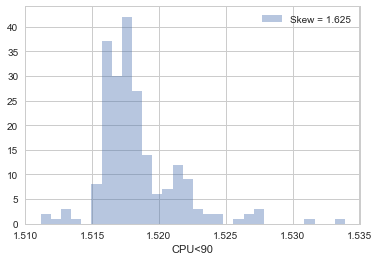

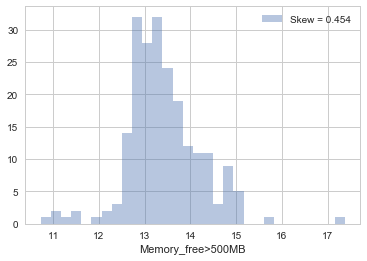

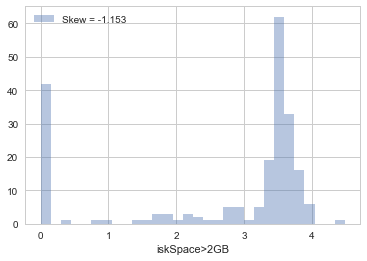

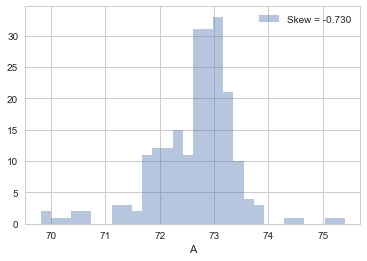

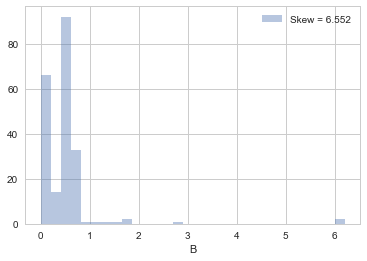

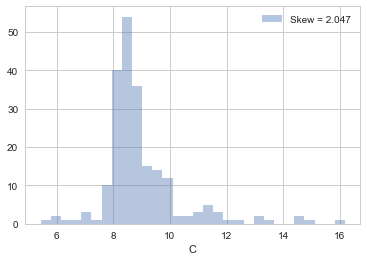

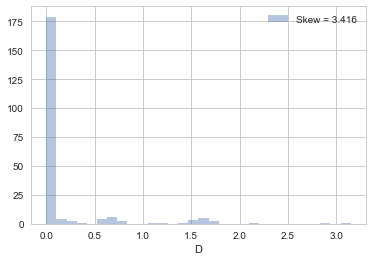

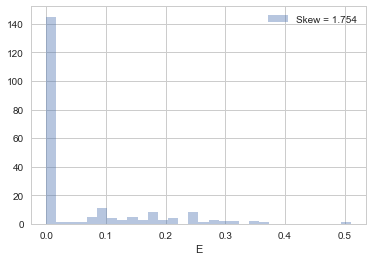

In [31]:


for feat in features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()



In [32]:


# Detect observations with more than one outlier

def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in df.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(df[features]))))

 

The dataset contains 14 observations with more than 2 outliers


A box plot (or box-and-whisker plot) shows the distribution of quantitative data in a way that facilitates comparisons between variables or across levels of a categorical variable. The box shows the quartiles of the dataset while the whiskers extend to show the rest of the distribution, except for points that are determined to be “outliers” using a method that is a function of the inter-quartile range ????? HOW DO BOXPLOT WORKS??????

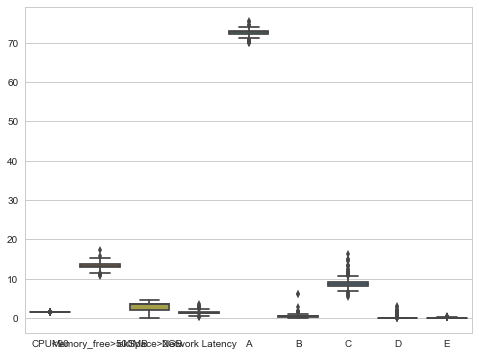

In [33]:


plt.figure(figsize=(8,6))
sns.boxplot(df[features])
plt.show()



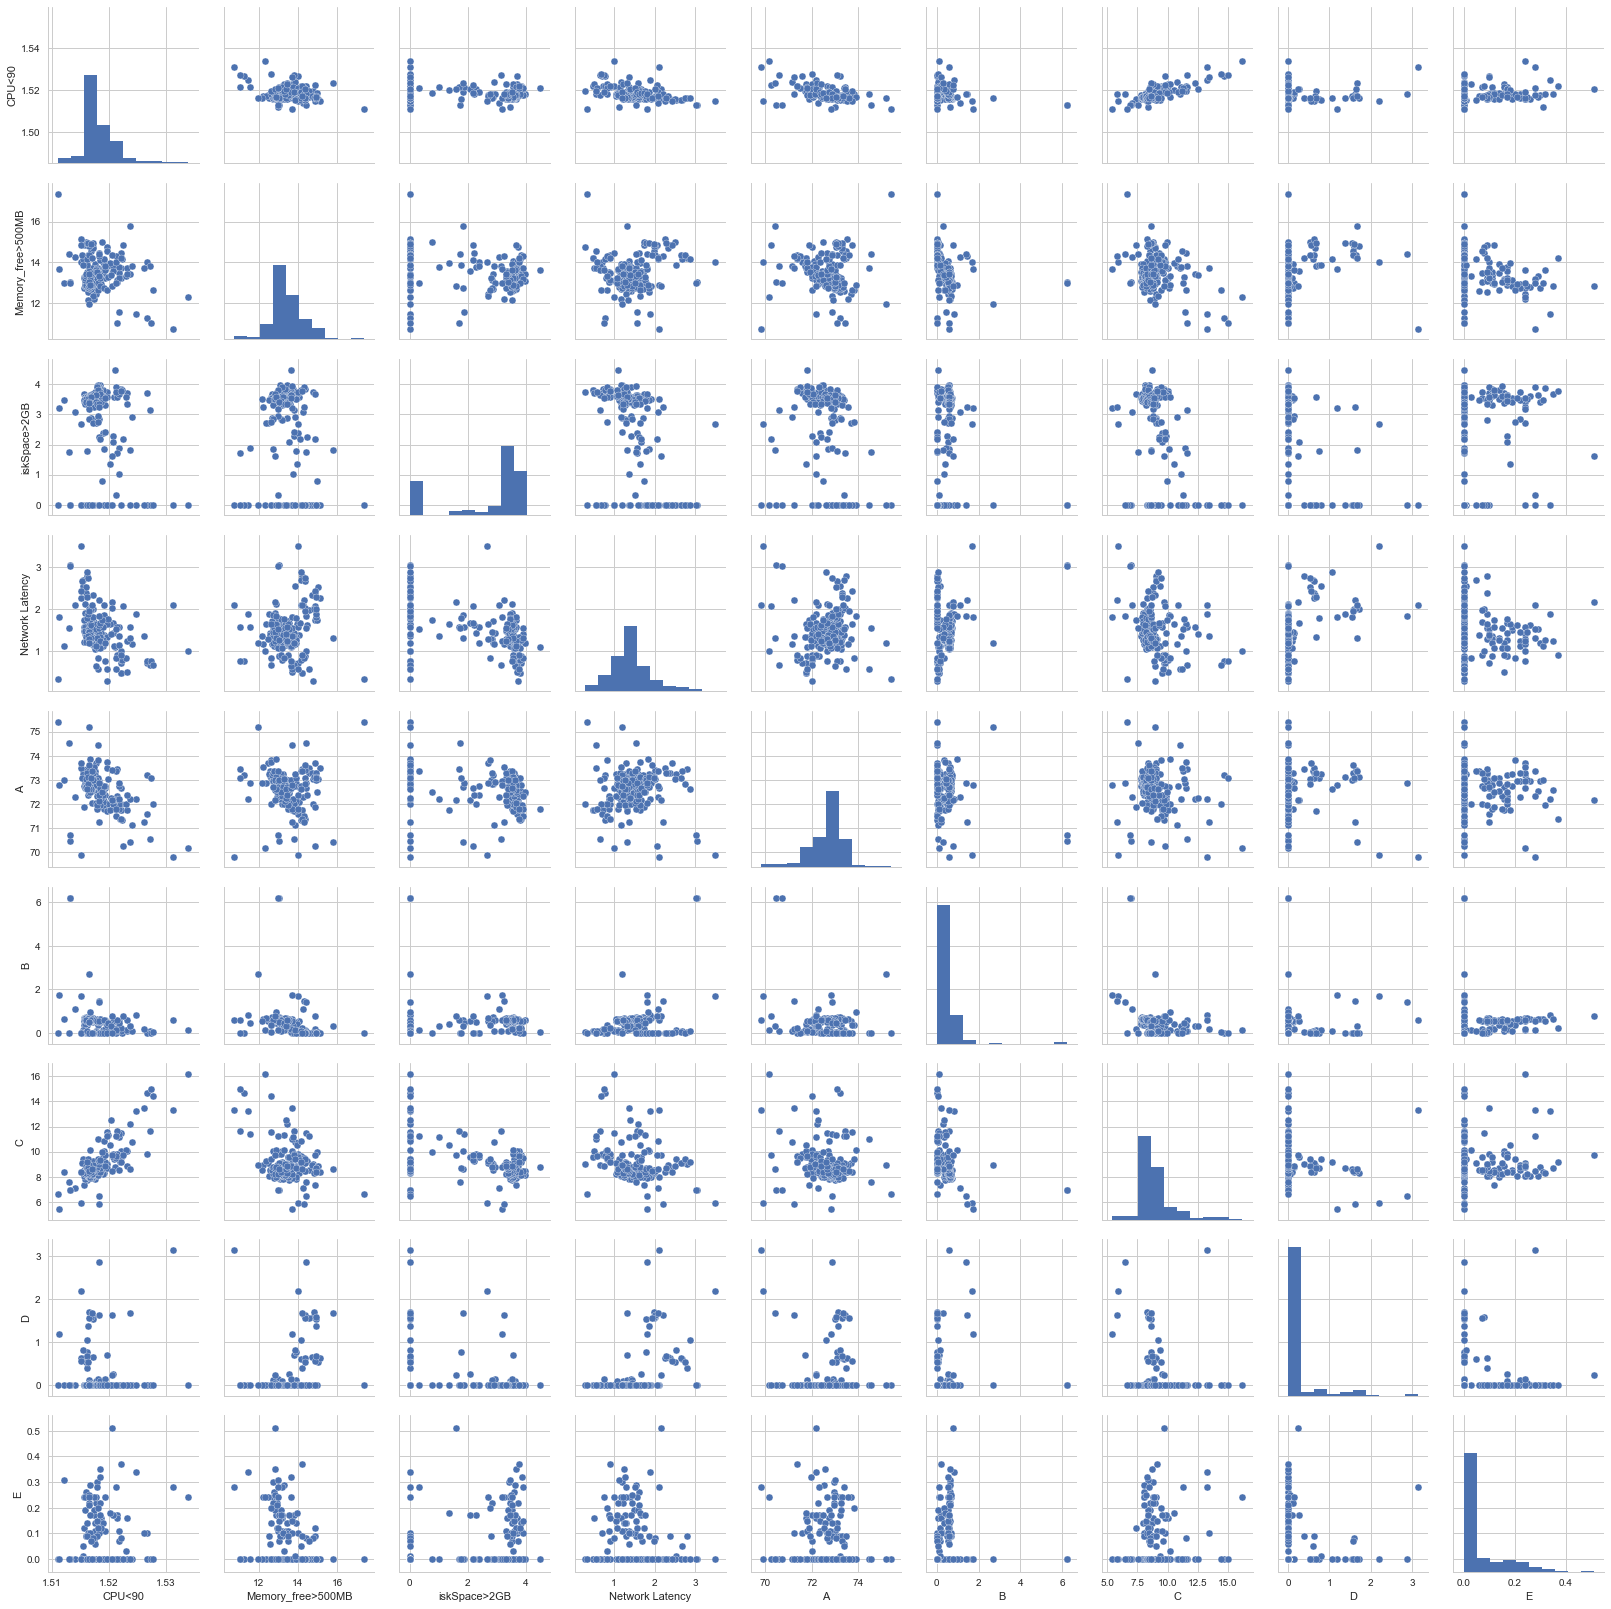

In [34]:
plt.figure(figsize=(8,8))
sns.pairplot(df[features],palette='coolwarm')
plt.show()

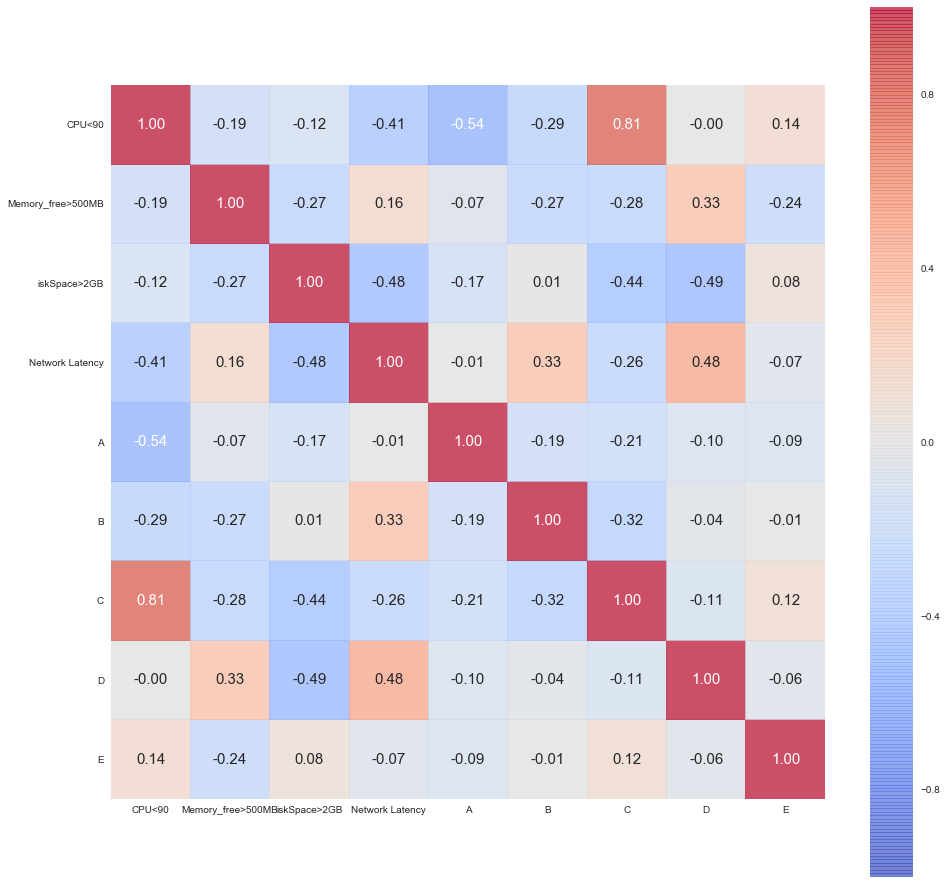

In [35]:


corr = df[features].corr()
plt.figure(figsize=(16,16))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= features, yticklabels= features, alpha = 0.7,   cmap= 'coolwarm')
plt.show()



In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
CPU<90               214 non-null float64
Memory_free>500MB    214 non-null float64
iskSpace>2GB         214 non-null float64
Network Latency      214 non-null float64
A                    214 non-null float64
B                    214 non-null float64
C                    214 non-null float64
D                    214 non-null float64
E                    214 non-null float64
Type                 214 non-null int64
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [37]:


outlier_indices = outlier_hunt(df[features])
df = df.drop(outlier_indices).reset_index(drop=True)
print(df.shape)



(200, 10)


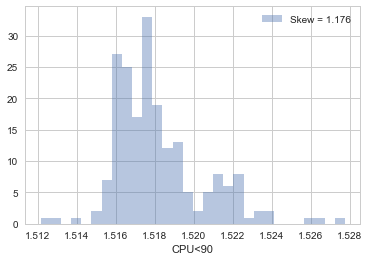

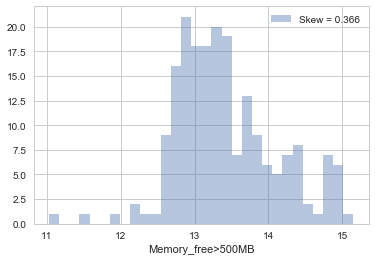

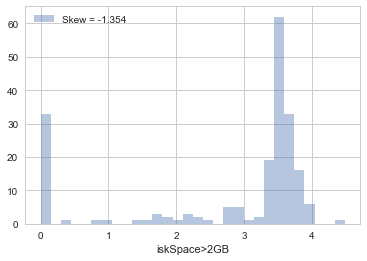

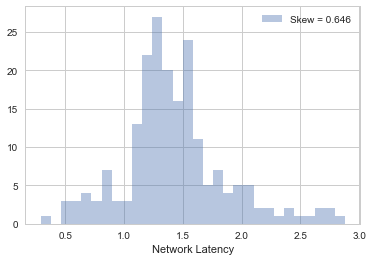

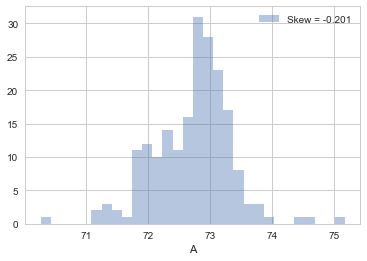

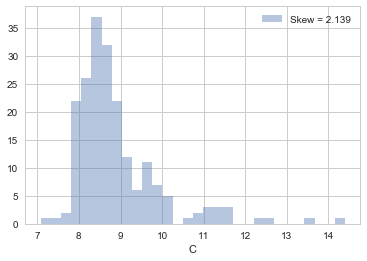

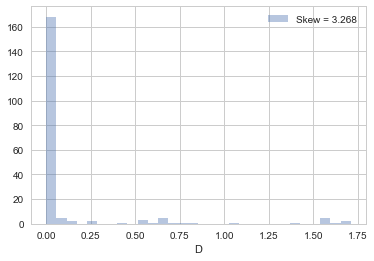

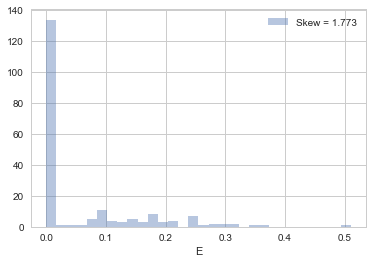

In [38]:


for feat in features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde=False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()



In [39]:
df['Type'].value_counts()

2    70
1    70
7    25
3    17
5    10
6     8
Name: Type, dtype: int64

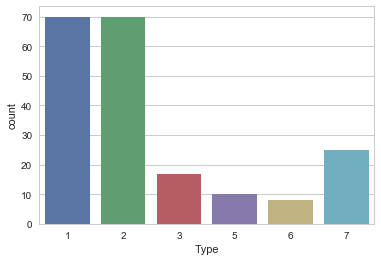

In [40]:
sns.countplot(df['Type'])
plt.show()

In [41]:
# Define X as features and y as lablels
X = df[features] 
y = df['Type'] 
# set a seed and a test size for splitting the dataset 
seed = 7
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size , random_state = seed)

In [42]:


features_boxcox = []

for feature in features:
    bc_transformed, _ = boxcox(df[feature]+1)  # shift by 1 to avoid computing log of negative values
    features_boxcox.append(bc_transformed)

features_boxcox = np.column_stack(features_boxcox)
df_bc = pd.DataFrame(data=features_boxcox, columns=features)
df_bc['Type'] = df['Type']



In [43]:
df_bc.describe()

CPU<90  Memory_free>500MB  iskSpace>2GB  Network Latency  \
count  200.000000         200.000000    200.000000       200.000000   
mean     0.002223           0.910643     14.813501         0.955244   
std      0.000000           0.003076      8.011923         0.217702   
min      0.002223           0.897962      0.000000         0.261374   
25%      0.002223           0.908540     10.569803         0.850076   
50%      0.002223           0.910269     18.555034         0.938477   
75%      0.002223           0.912445     19.835863         1.060851   
max      0.002223           0.917711     31.408319         1.561947   

                  A           B             C           D           E  \
count  2.000000e+02  200.000000  2.000000e+02  200.000000  200.000000   
mean   6.066998e+09    0.342872  1.999247e-01    0.013377    0.019141   
std    2.873436e+08    0.213507  8.577883e-07    0.031188    0.027757   
min    5.004527e+09    0.000000  1.999213e-01    0.000000    0.000000   
25%    5.893055e+09    0.122922  1.999242e-01    0.000000    0.000000   
50%    6.106880e+09    0.447403  1.999247e-01    0.000000    0.000000   
75%    6.238683e+09    0.480536  1.999252e-01    0.000000    0.051652   
max    7.292985e+09    1.392148  1.999269e-01    0.091142    0.068796   

             Type  
count  200.000000  
mean     2.670000  
std      2.054802  
min      1.000000  
25%      1.000000  
50%      2.000000  
75%      3.000000  
max      7.000000

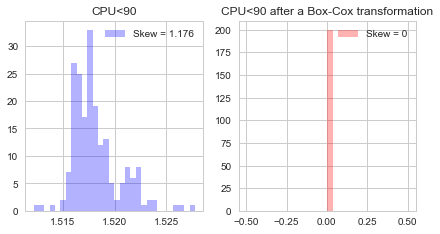

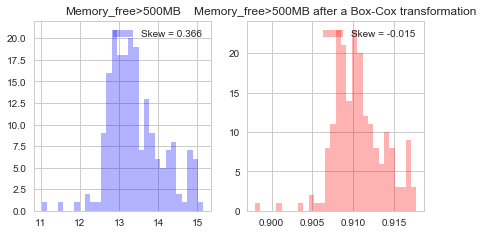

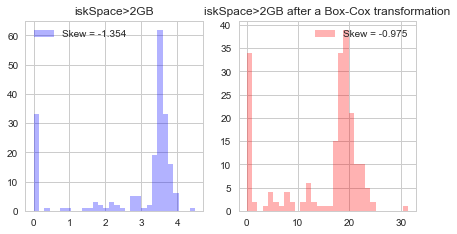

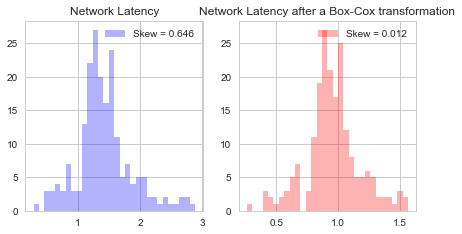

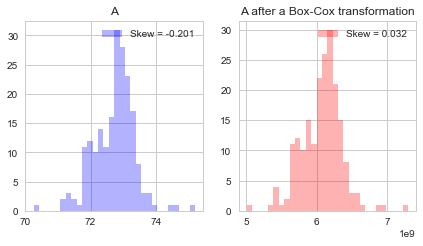

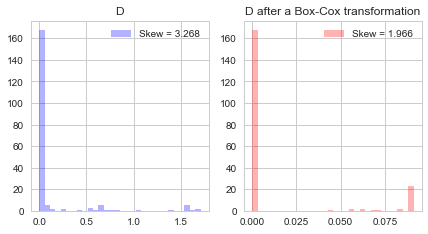

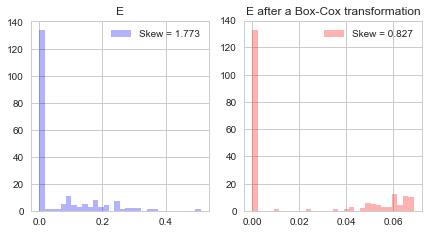

In [44]:
for feature in features:
    fig, ax = plt.subplots(1,2,figsize=(7,3.5))    
    ax[0].hist(df[feature], color='blue', bins=30, alpha=0.3, label='Skew = %s' %(str(round(df[feature].skew(),3))) )
    ax[0].set_title(str(feature))   
    ax[0].legend(loc=0)
    ax[1].hist(df_bc[feature], color='red', bins=30, alpha=0.3, label='Skew = %s' %(str(round(df_bc[feature].skew(),3))) )
    ax[1].set_title(str(feature)+' after a Box-Cox transformation')
    ax[1].legend(loc=0)
    plt.show()

box-cox transform??????????? How it works????

In [45]:
# check if skew is closer to zero after a box-cox transform
for feature in features:
    delta = np.abs( df_bc[feature].skew() / df[feature].skew() )
    if delta < 1.0 :
        print('Feature %s is less skewed after a Box-Cox transform' %(feature))
    else:
        print('Feature %s is more skewed after a Box-Cox transform'  %(feature))

Feature CPU<90 is less skewed after a Box-Cox transform
Feature Memory_free>500MB is less skewed after a Box-Cox transform
Feature iskSpace>2GB is less skewed after a Box-Cox transform
Feature Network Latency is less skewed after a Box-Cox transform
Feature A is less skewed after a Box-Cox transform
Feature B is less skewed after a Box-Cox transform
Feature C is less skewed after a Box-Cox transform
Feature D is less skewed after a Box-Cox transform
Feature E is less skewed after a Box-Cox transform


XGBoost : TO Do??????????????

Evaluating Algorithms

Using XGBoost : Feature importance

In [46]:


#model_importances = XGBClassifier()
start = time()
#model_importances.fit(X_train, y_train)
print('Elapsed time to train XGBoost  %.3f seconds' %(time()-start))
#plot_importance(model_importances)
#plt.show()



Elapsed time to train XGBoost  0.000 seconds


In [47]:


pca = PCA(random_state = seed)
pca.fit(X_train)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
plt.figure(figsize=(8,6))
plt.bar(range(1,len(cum_var_exp)+1), var_exp, align= 'center', label= 'individual variance explained', \
       alpha = 0.7)
plt.step(range(1,len(cum_var_exp)+1), cum_var_exp, where = 'mid' , label= 'cumulative variance explained', \
        color= 'red')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xticks(np.arange(1,len(var_exp)+1,1))
plt.legend(loc='center right')
plt.show()

# Cumulative variance explained
for i, sum in enumerate(cum_var_exp):
    print("PC" + str(i+1), "Cumulative variance: %.3f% %" %(cum_var_exp[i]*100))



PC1 Cumulative variance: 58.837%
PC2 Cumulative variance: 80.887%
PC3 Cumulative variance: 94.102%
PC4 Cumulative variance: 97.748%
PC5 Cumulative variance: 99.159%
PC6 Cumulative variance: 99.752%
PC7 Cumulative variance: 99.977%
PC8 Cumulative variance: 100.000%
PC9 Cumulative variance: 100.000%


Compare Algorithms

In [48]:


n_components = 5
pipelines = []
n_estimators = 200

#print(df.shape)
pipelines.append( ('SVC',
                   Pipeline([
                              ('sc', StandardScaler()),
#                               ('pca', PCA(n_components = n_components, random_state=seed ) ),
                             ('SVC', SVC(random_state=seed))]) ) )


pipelines.append(('KNN',
                  Pipeline([ 
                              ('sc', StandardScaler()),
#                             ('pca', PCA(n_components = n_components, random_state=seed ) ),
                            ('KNN', KNeighborsClassifier()) ])))
pipelines.append( ('RF',
                   Pipeline([
                              ('sc', StandardScaler()),
#                              ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                             ('RF', RandomForestClassifier(random_state=seed, n_estimators=n_estimators)) ]) ))


pipelines.append( ('Ada',
                   Pipeline([ 
                              ('sc', StandardScaler()),
#                              ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                    ('Ada', AdaBoostClassifier(random_state=seed,  n_estimators=n_estimators)) ]) ))

pipelines.append( ('ET',
                   Pipeline([
                              ('sc', StandardScaler()),
#                              ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                             ('ET', ExtraTreesClassifier(random_state=seed, n_estimators=n_estimators)) ]) ))
pipelines.append( ('GB',
                   Pipeline([ 
                             ('sc', StandardScaler()),
#                             ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                             ('GB', GradientBoostingClassifier(random_state=seed)) ]) ))

pipelines.append( ('LR',
                   Pipeline([
                              ('sc', StandardScaler()),
#                               ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                             ('LR', LogisticRegression(random_state=seed)) ]) ))

results, names, times  = [], [] , []
num_folds = 10
scoring = 'accuracy'

for name, model in pipelines:
    start = time()
    kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring = scoring,
                                n_jobs=-1) 
    t_elapsed = time() - start
    results.append(cv_results)
    names.append(name)
    times.append(t_elapsed)
    msg = "%s: %f (+/- %f) performed in %f seconds" % (name, 100*cv_results.mean(), 
                                                       100*cv_results.std(), t_elapsed)
    print(msg)


fig = plt.figure(figsize=(12,8))    
fig.suptitle("Algorithms comparison")
ax = fig.add_subplot(1,1,1)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()



SVC: 71.430587 (+/- 8.222655) performed in 6.908021 seconds
KNN: 67.772914 (+/- 10.418318) performed in 6.653017 seconds
RF: 78.190797 (+/- 9.015282) performed in 8.389055 seconds
Ada: 46.211231 (+/- 7.623465) performed in 9.508436 seconds
ET: 75.904677 (+/- 6.876377) performed in 7.241079 seconds
GB: 74.091032 (+/- 11.114344) performed in 7.319053 seconds
LR: 70.025502 (+/- 9.168266) performed in 6.223021 seconds
